# CAN 2025 Match Outcome Prediction – SBI Student Challenge 2025

This notebook aims to analyze and predict the outcomes of football matches for the CAN 2025 tournament.
We leverage historical performance of participating teams to estimate win probabilities, draw likelihoods,
and key performance indicators influencing match outcomes.

The objective is to provide actionable insights for teams and analysts by combining Exploratory Data Analysis (EDA)
with a simple, interpretable predictive model.


In [26]:
# -----------------------------
# 1. IMPORT LIBRARIES
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import pickle

## Data Loading and Filtering

We load historical match results and focus on the last 5 years to capture recent team performance.
Only matches involving the 25 qualified teams for CAN 2025 are retained.

This ensures that our analysis reflects current team form rather than outdated results.


In [37]:
# -----------------------------
# 2. LOAD DATA
# -----------------------------
# Load historical match results
df = pd.read_csv('results.csv', parse_dates=['date'])

# Filter for recent matches (last 5 years)
recent_cutoff = pd.Timestamp.now() - pd.DateOffset(years=5)
df = df[df['date'] >= recent_cutoff]

# Define AFCON 2025 qualified teams
AFCON_TEAMS = [
    'Morocco','Mali','Zambia','Comoros',
    'Egypt','South Africa','Angola','Zimbabwe',
    'Nigeria','Tunisia','Uganda','Tanzania',
    'Senegal','DR Congo','Benin','Botswana',
    'Algeria','Burkina Faso','Equatorial Guinea','Sudan',
    'Ivory Coast','Guinea','Guinea-Bissau','Cape Verde','Namibia'
]

# Keep only matches involving AFCON teams
df = df[df['home_team'].isin(AFCON_TEAMS) | df['away_team'].isin(AFCON_TEAMS)]
print(f"Filtered AFCON matches: {len(df)}")

Filtered AFCON matches: 1019


## Team-Level Performance Metrics

For each team, we calculate:
- Number of matches played
- Wins, draws, and losses
- Win rate and draw rate
- Goal difference
- Average goals scored and conceded per match

These metrics summarize the historical performance and form of each team and serve as features
for our predictive model.


In [28]:
# -----------------------------
# 3. COMPUTE TEAM STATISTICS
# -----------------------------
teams = AFCON_TEAMS
team_stats = {}

for team in teams:
    matches = df[(df['home_team']==team) | (df['away_team']==team)]

    wins = ((matches['home_team']==team) & (matches['home_score']>matches['away_score'])) | \
           ((matches['away_team']==team) & (matches['away_score']>matches['home_score']))
    draws = matches['home_score'] == matches['away_score']
    losses = ((matches['home_team']==team) & (matches['home_score']<matches['away_score'])) | \
             ((matches['away_team']==team) & (matches['away_score']<matches['home_score']))

    goals_scored = matches.apply(lambda x: x['home_score'] if x['home_team']==team else x['away_score'], axis=1).sum()
    goals_conceded = matches.apply(lambda x: x['away_score'] if x['home_team']==team else x['home_score'], axis=1).sum()

    total = len(matches)

    team_stats[team] = {
        'matches': total,
        'wins': wins.sum(),
        'draws': draws.sum(),
        'losses': losses.sum(),
        'win_rate': wins.sum()/total if total>0 else 0,
        'draw_rate': draws.sum()/total if total>0 else 0,
        'goal_difference': goals_scored - goals_conceded,
        'avg_goals_scored': goals_scored/total if total>0 else 0,
        'avg_goals_conceded': goals_conceded/total if total>0 else 0
    }

# Convert to DataFrame and sort by win rate
team_stats_df = pd.DataFrame.from_dict(team_stats, orient='index').sort_values('win_rate', ascending=False)

# Save team stats
team_stats_df.to_csv("team_stats.csv", index=True)
print("team_stats.csv saved!")

team_stats.csv saved!


## Exploratory Data Analysis (EDA)

Visualizations help us identify trends and patterns:
1. **Win Rate Distribution:** Shows how frequently each team wins in recent matches.
2. **Attack vs Defense:** Plots average goals scored vs goals conceded, highlighting offensive and defensive strengths.

These plots allow us to spot top-performing teams and teams with imbalanced strengths,
which may influence predictions.


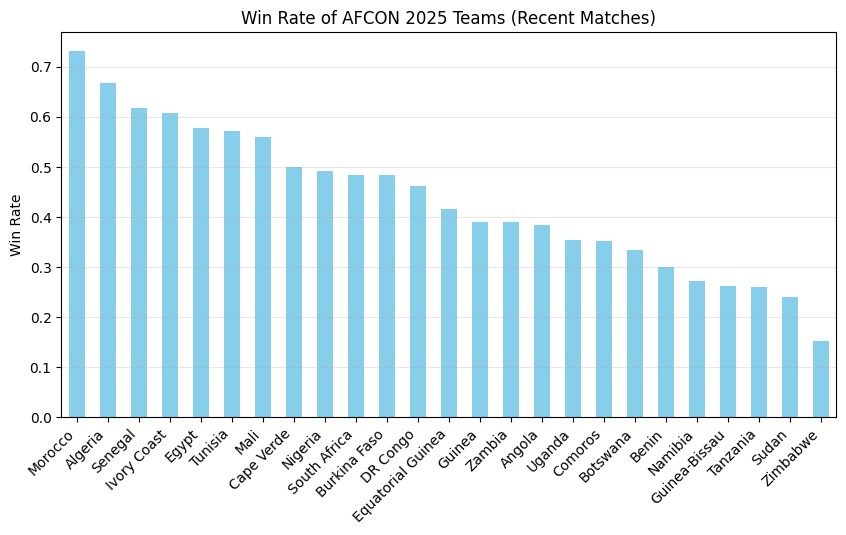

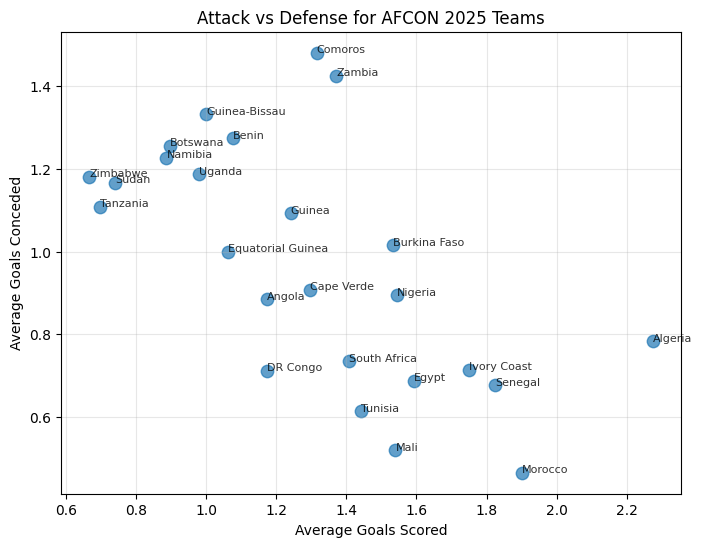

In [29]:
# -----------------------------
# 4. VISUALIZATIONS
# -----------------------------
# 4.1 Win rate distribution
plt.figure(figsize=(10,5))
team_stats_df['win_rate'].plot(kind='bar', color='skyblue')
plt.title('Win Rate of AFCON 2025 Teams (Recent Matches)')
plt.ylabel('Win Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.show()

# 4.2 Attack vs Defense
plt.figure(figsize=(8,6))
plt.scatter(team_stats_df['avg_goals_scored'], team_stats_df['avg_goals_conceded'], s=80, alpha=0.7)
for team in team_stats_df.index:
    plt.annotate(team, (team_stats_df.loc[team,'avg_goals_scored'], team_stats_df.loc[team,'avg_goals_conceded']),
                 fontsize=8, alpha=0.8)
plt.xlabel('Average Goals Scored')
plt.ylabel('Average Goals Conceded')
plt.title('Attack vs Defense for AFCON 2025 Teams')
plt.grid(True, alpha=0.3)
plt.show()

## Key Performance Drivers

We define three features to represent match-specific advantages:
1. **Goal Difference Advantage (goal_diff_adv):** Difference between expected goals scored and conceded.
2. **Win Rate Advantage (win_rate_adv):** Difference in historical win rates between home and away teams.
3. **Draw Rate Advantage (draw_rate_adv):** Difference in historical draw rates.

The target variable is binary:
- 1 if the home team wins
- 0 if the match is drawn or the away team wins

These features provide interpretable, team-level insights that feed into the predictive model.


In [30]:
# -----------------------------
# 5. FEATURE ENGINEERING
# -----------------------------
match_data = []

for _, match in df.iterrows():
    home = match['home_team']
    away = match['away_team']

    if home in team_stats and away in team_stats:
        home_stats = team_stats[home]
        away_stats = team_stats[away]

        # Feature: home advantage metrics
        goal_diff_adv = (home_stats['avg_goals_scored'] - away_stats['avg_goals_conceded']) - \
                        (away_stats['avg_goals_scored'] - home_stats['avg_goals_conceded'])
        win_rate_adv = home_stats['win_rate'] - away_stats['win_rate']
        draw_rate_adv = home_stats['draw_rate'] - away_stats['draw_rate']

        # Target variable: 1 if home wins, 0 otherwise
        target = 1 if match['home_score'] > match['away_score'] else 0

        match_data.append({
            'goal_diff_adv': goal_diff_adv,
            'win_rate_adv': win_rate_adv,
            'draw_rate_adv': draw_rate_adv,
            'target': target
        })

model_df = pd.DataFrame(match_data)
model_df.head()

,goal_diff_adv,win_rate_adv,draw_rate_adv,target
0,0.273333,-0.171111,-0.000741,1
1,-0.381720,-0.129704,-0.065860,0
2,0.305361,0.181818,-0.209790,0
3,-0.261675,-0.277778,-0.046699,0
4,0.258152,0.155797,0.030797,1


## Predictive Model – Binary Logistic Regression

We use a binary logistic regression model to predict the probability of a home team victory.
The model is simple, interpretable, and aligns with the challenge requirement for a predictive approach.

Training consists of splitting the dataset into train and test sets, fitting the model,
and evaluating its performance using accuracy and ROC metrics.


In [31]:
# -----------------------------
# 6. MODEL TRAINING
# -----------------------------
X = model_df[['goal_diff_adv','win_rate_adv','draw_rate_adv']]
y = model_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Binary logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Training accuracy: {accuracy:.2%}")

Training accuracy: 72.73%


## Model Evaluation

We assess model performance using:
- **Accuracy:** Percentage of correctly predicted match outcomes.
- **Feature Coefficients:** Indicates the impact of each feature on win probability. Positive coefficients increase probability, negative decrease it.
- **ROC Curve and AUC:** Evaluates the trade-off between true positive and false positive rates for home team wins.

These metrics help validate that our model captures meaningful patterns in team performance.


goal_diff_adv: decreases win probability (coef=-0.245)
win_rate_adv: increases win probability (coef=3.511)
draw_rate_adv: increases win probability (coef=0.528)


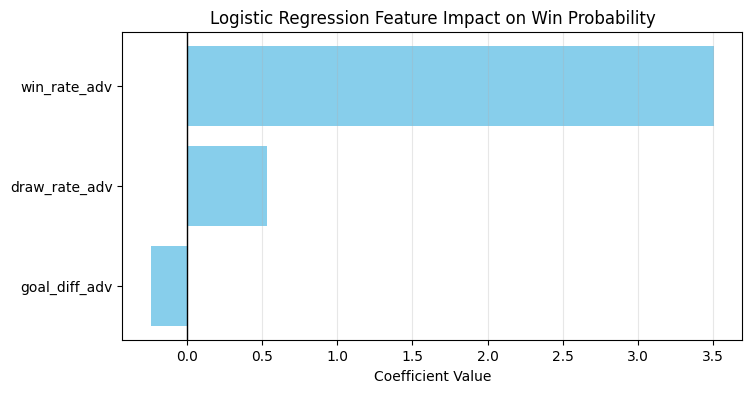

In [32]:
# -----------------------------
# 7. FEATURE IMPORTANCE
# -----------------------------
for feature, coef in zip(X.columns, model.coef_[0]):
    direction = "increases" if coef > 0 else "decreases"
    print(f"{feature}: {direction} win probability (coef={coef:.3f})")

coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0]
}).sort_values('coefficient')

plt.figure(figsize=(8,4))
plt.barh(coef_df['feature'], coef_df['coefficient'], color='skyblue')
plt.axvline(0, color='black', linewidth=1)
plt.title('Logistic Regression Feature Impact on Win Probability')
plt.xlabel('Coefficient Value')
plt.grid(axis='x', alpha=0.3)
plt.show()


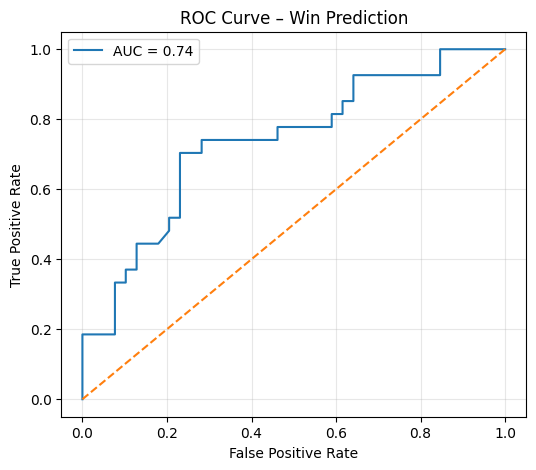

In [33]:

# -----------------------------
# 8. ROC CURVE
# -----------------------------
y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Win Prediction')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [34]:

# -----------------------------
# 9. SAVE MODEL
# -----------------------------
with open("logreg_model.pkl", "wb") as f:
    pickle.dump(model, f)
print("logreg_model.pkl saved!")

logreg_model.pkl saved!


## Match Outcome Predictions

Using the trained model, we predict win probabilities for specific matches:
- Probabilities for home team wins, away team wins, and draw likelihood.
- Adjustments for draw probability are included to improve interpretability.

Predictions are explained in business terms, showing the likelihood of outcomes for upcoming matches.


In [35]:
# -----------------------------
# 10. PREDICTION FUNCTION
# -----------------------------
def predict_match(team, opponent):
    """
    Predict match outcome probabilities for two teams.
    """
    if team not in team_stats or opponent not in team_stats:
        print("❌ Invalid team names")
        return

    t_stats = team_stats[team]
    o_stats = team_stats[opponent]

    # Feature calculations
    goal_diff_adv = (t_stats['avg_goals_scored'] - o_stats['avg_goals_conceded']) - \
                    (o_stats['avg_goals_scored'] - t_stats['avg_goals_conceded'])
    win_rate_adv = t_stats['win_rate'] - o_stats['win_rate']
    draw_rate_adv = (t_stats.get('draws', 0)/t_stats['matches']) - (o_stats.get('draws', 0)/o_stats['matches'])


    features = pd.DataFrame(
        [[goal_diff_adv, win_rate_adv, draw_rate_adv]],
        columns=['goal_diff_adv','win_rate_adv','draw_rate_adv']
    )

    # Predict probabilities (binary logistic regression)
    prob_team_win = model.predict_proba(features)[0][1]
    prob_opponent_win = 1 - prob_team_win

    # Draw probability from historical data
    total_games = t_stats['matches'] + o_stats['matches']
    draw_prob = (t_stats.get('draws', 0) + o_stats.get('draws', 0)) / total_games
    draw_prob = np.clip(draw_prob, 0, 1)

    # Adjust win probabilities to account for draw
    prob_team_win *= (1 - draw_prob)
    prob_opponent_win *= (1 - draw_prob)

    # Determine predicted result
    if abs(prob_team_win - prob_opponent_win) < 0.05:
        predicted = "Draw likely"
    else:
        predicted = team if prob_team_win > prob_opponent_win else opponent

    # Print results
    print(f"\n {team} vs {opponent}")
    print(f"   {team} win probability: {prob_team_win:.1%}")
    print(f"   {opponent} win probability: {prob_opponent_win:.1%}")
    print(f"   Draw probability: {draw_prob:.1%}")
    print(f"   Predicted result: {predicted}")

In [36]:
# Example predictions
predict_match('Morocco','Algeria')
predict_match('Nigeria','Senegal')
predict_match('Botswana','Namibia')


 Morocco vs Algeria
   Morocco win probability: 42.2%
   Algeria win probability: 37.1%
   Draw probability: 20.7%
   Predicted result: Morocco

 Nigeria vs Senegal
   Nigeria win probability: 24.3%
   Senegal win probability: 47.7%
   Draw probability: 28.0%
   Predicted result: Senegal

 Botswana vs Namibia
   Botswana win probability: 36.3%
   Namibia win probability: 40.8%
   Draw probability: 22.9%
   Predicted result: Draw likely


## Conclusion and Insights

- The analysis identifies key team performance factors influencing match outcomes: goal difference, win rate, and draw rate.
- Logistic regression provides a simple yet interpretable prediction mechanism.
- Visualizations and metrics allow analysts to understand which teams have competitive advantages.
- The model can be extended for interactive use in dashboards or Streamlit apps for real-time scenario analysis.

Overall, this approach demonstrates how historical data can support actionable predictions for CAN 2025 matches.
